# Hamiltonian simulation with Gray code encoding - statevector simulator

In [15]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
# import scipy
from pprint import pprint
from tqdm import tqdm

from scipy.linalg import lstsq
import scipy as sp

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

## Playing with Pauli and WeightedPauli operators

In [28]:
## H is always in qiskit order (right to left)
## String form is also in that order 
## State vector results in order [00,01,10,11]
from scipy.linalg import eigh
n_qubits=2
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
print(H.pauli_coeffs)
# H.matrix
exact_eigenvalue,_=eigh(H.matrix)
print(exact_eigenvalue)

{'IX': -7.813951636042159, 'ZX': 3.5273445861715977, 'XI': -3.913118960624632, 'XZ': 3.913118960624632, 'II': 14.3283547225, 'ZI': -8.4216452775, 'IZ': -1.4216452774999997, 'ZZ': -4.9216452775}
[-2.14398103  6.07151323 17.75169828 35.63418841]


In [17]:
## vector of WeightedPauliOperators representing vector Sigma -- a list of all pauli terms with odd number of Y gates
sigmas=get_sigma_pauli_terms(n_qubits)

## b=i[H,sigma]
b_pauli_terms=b_terms(H,sigmas)

##S_{ij}=2sigma_i.sigma_j
S_pauli_terms=S_terms(sigmas)

## Set of all pauli terms needed to compute H, b, and S
pauli_set=get_intersection_pauli_terms(H,b_pauli_terms,S_pauli_terms)

## Organize pauli set into commuting sets of pauli operators 
commuting_sets=get_commuting_sets(sorted(pauli_set))
print("key, [paulis in set]")
for p in commuting_sets:
    print(p, commuting_sets[p])

key, [paulis in set]
XX ['II', 'IX', 'XI', 'XX']
XY ['IY', 'XY']
XZ ['IZ', 'XZ']
YX ['YI', 'YX']
YY ['YY']
YZ ['YZ']
ZX ['ZI', 'ZX']
ZY ['ZY']
ZZ ['ZZ']


In [85]:
#####################################       
# Prepare and run the evolution circuit
#####################################       
num_iterations=20
delta_time=0.01
n_qubits=3

initialization="zeros"
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
exact_eigenvalue,_=eigh(H.matrix)
print(exact_eigenvalue)

backend = 'statevector_simulator'
sv_energies,Ccoefs_sv=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=None)

# threshold=1e-2
# backend = 'qasm_simulator'
# qasm_energies,Ccoefs_qasm=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=threshold,cstep=None)



  0%|          | 0/20 [00:00<?, ?it/s]

[-2.21503787  2.52159867  8.32143272 16.32766303 26.59557563 39.95924445
 57.74792829 83.05501397]


100%|██████████| 20/20 [00:08<00:00,  2.40it/s]


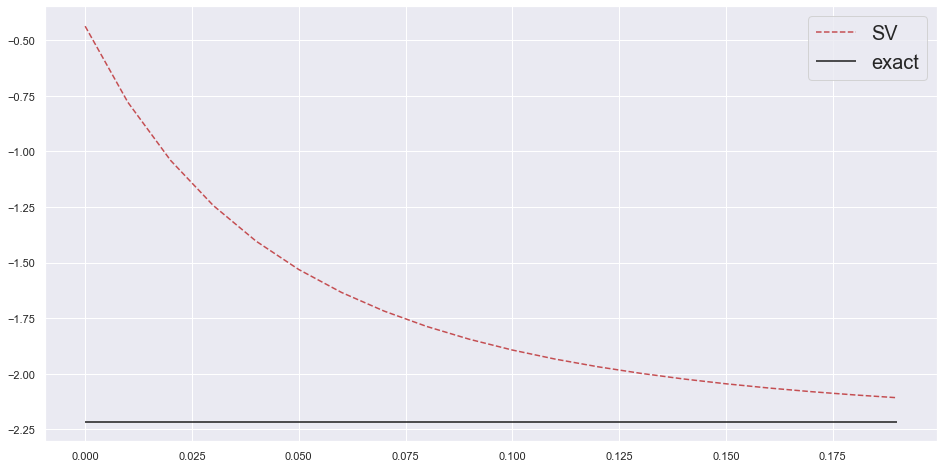

In [86]:
time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'r--',label="SV")
# plt.plot(time,qasm_energies,'b^',label="qasm")
plt.hlines(exact_eigenvalue[0], time[0], time[-1], colors='k', linestyles='solid', label='exact',)
plt.legend(prop={'size': 20})

In [87]:
def normalization_coefficients(Ccoef):
    ncoefs=np.zeros(len(Ccoef))
    ncoefs[0]=1/np.sqrt(Ccoef[0])
    for r in range(1,len(Ccoef)):
        Cr=Ccoef[r-1]
        nr=ncoefs[r-1]
        ncoefs[r]=nr/np.sqrt(Cr)
    
    return ncoefs

ncoefs=normalization_coefficients(Ccoefs_sv)
print(ncoefs)

[0.99566257 0.99134396 0.98371098 0.97363315 0.96174749 0.94852753
 0.93432968 0.91942514 0.90402231 0.88828271 0.87233242 0.85627053
 0.84017528 0.82410872 0.80812016 0.7922489  0.77652621 0.76097694
 0.74562079 0.73047324]


In [108]:
from scipy.linalg import eig
## Construct overlap matrix
lanczos_stride=2
max_krylov_dim=8

print("stride",lanczos_stride)
index_list=[]
for i in range(0,num_iterations,lanczos_stride):
    index_list.append(i)

dim=min(len(index_list),max_krylov_dim)

index_list=index_list[-dim:]
print(index_list)


Omatrix=np.asmatrix(np.zeros((dim,dim)))
Hmatrix=np.asmatrix(np.zeros((dim,dim)))

for i in range(dim):
    for j in range(dim):
        l=index_list[j]
        lp=index_list[i]
        k=(l+lp)/2
#         print(k)
        k=int(k)
#         Omatrix[i,j]=(Ccoefs_sv[k]**2)
        Omatrix[i,j]=(ncoefs[l]*ncoefs[lp])/(ncoefs[k]**2)


# print("")
## Construct H matrix 
for i in range(0,dim):
    for j in range(0,dim):
        l=index_list[j]
        lp=index_list[i]
        k=int((l+lp)/2)
        Hmatrix[i,j]=Omatrix[i,j]*sv_energies[k]
# print(Hmatrix)


eigs,_=eigh(Hmatrix,Omatrix)
print(eigs)
print("QITE:     ",sv_energies[-1])
print("QLanczos: ",eigs.real[0])
print("Exact:    ",exact_eigenvalue[0])

stride 2
[4, 6, 8, 10, 12, 14, 16, 18]
[-1587.89720593    -2.2150369      2.51354455     8.00706707
    15.06518887    23.1107599     30.58428141    34.58007647]
QITE:      -2.107838690508591
QLanczos:  -1587.897205933859
Exact:     -2.2150378722680117
